<a href="https://colab.research.google.com/github/kridtapon/SAR-TrendLock-System/blob/main/WFO_SAR_TrendLock_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.0 MB/s eta 0:00:00


Streaming output truncated to the last 5000 lines.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['ATR'] = calculate_atr(train_data, atr_window)
<ipython-input-2-c17a4d3ede94>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Entry'] = (train_data['Close'] > train_data['SAR']) & (train_data['ATR'] > entry_atr_threshold)
<ipython-input-2-c17a4d3ede94>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/


Walk-Forward Optimization Results:
   Year                Best_Params  Test_Return
0  2020  (0.01, 0.1, 13, 0.1, 0.7)     0.256091
1  2021   (0.01, 0.1, 5, 0.1, 0.7)     0.002144
2  2022  (0.06, 0.2, 29, 0.1, 0.9)    -0.016332
3  2023   (0.01, 0.1, 9, 0.3, 0.7)     0.103102
4  2024  (0.05, 0.1, 17, 0.1, 0.9)     0.720289
5  2025   (0.04, 0.1, 5, 0.3, 0.9)     0.000000


<ipython-input-2-c17a4d3ede94>:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['SAR'] = calculate_parabolic_sar(yearly_data, params[0], params[1])
<ipython-input-2-c17a4d3ede94>:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['ATR'] = calculate_atr(yearly_data, params[2])
<ipython-input-2-c17a4d3ede94>:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           247635.018263
Total Return [%]                       147.635018
Benchmark Return [%]                   145.632566
Max Gross Exposure [%]                      100.0
Total Fees Paid                        333.965189
Max Drawdown [%]                        24.268047
Max Drawdown Duration                       313.0
Total Trades                                    2
Total Closed Trades                             1
Total Open Trades                               1
Open Trade PnL                      130602.590725
Win Rate [%]                                100.0
Best Trade [%]                           17.04946
Worst Trade [%]                          17.04946
Avg Winning Trade [%]                    17.04946
Avg Losing Trade [%]                          NaN


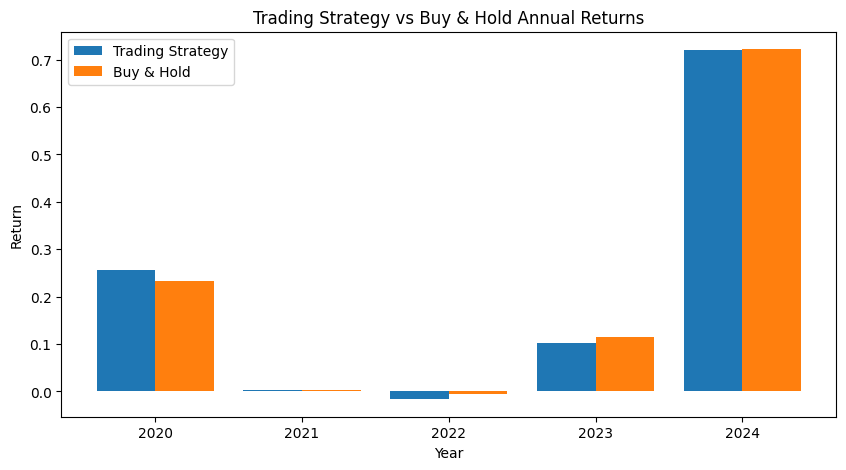

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt
import itertools

# Function to calculate Parabolic SAR
def calculate_parabolic_sar(df, initial_af=0.02, max_af=0.2):
    sar = [df['Close'][0]]  # Initial SAR value is set to the first closing price
    af = initial_af  # Acceleration Factor (AF)
    ep = df['High'][0]  # Extreme Point (EP) for an uptrend, starts as the first high value
    uptrend = True  # We start with an uptrend
    for i in range(1, len(df)):
        if uptrend:
            sar.append(sar[-1] + af * (ep - sar[-1]))
            # Ensure SAR does not exceed the previous low
            sar[-1] = min(sar[-1], df['Low'][i-1])
            if df['Low'][i] < sar[-1]:
                uptrend = False
                sar[-1] = ep  # Set SAR to EP when trend reverses
                ep = df['Low'][i]  # New EP for downtrend
                af = initial_af  # Reset AF
        else:
            sar.append(sar[-1] + af * (ep - sar[-1]))
            # Ensure SAR does not exceed the previous high
            sar[-1] = max(sar[-1], df['High'][i-1])
            if df['High'][i] > sar[-1]:
                uptrend = True
                sar[-1] = ep  # Set SAR to EP when trend reverses
                ep = df['High'][i]  # New EP for uptrend
                af = initial_af  # Reset AF

        # Update the AF based on the maximum value
        if (ep == df['High'][i] and uptrend) or (ep == df['Low'][i] and not uptrend):
            af = min(af + initial_af, max_af)  # Increment AF but limit it to max_af
    return pd.Series(sar, index=df.index)

# Calculate the Average True Range (ATR)
def calculate_atr(df, window=14):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window).mean()
    return atr

# Walk-forward optimization with Parabolic SAR and ATR thresholds
def walk_forward_optimization_parabolic_sar(df, start_year, end_year):
    results = []

    # Define dynamic ranges for Parabolic SAR and ATR thresholds
    initial_af_range = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]  # Range for initial AF
    max_af_range = [0.1, 0.2, 0.3, 0.4, 0.5]  # Range for max AF
    atr_window_range = range(5, 30, 2)  # ATR window periods
    entry_optimize_range = [0.1, 0.2, 0.3]  # Quantile values for entry ATR threshold
    exit_optimize_range = [0.7, 0.8, 0.9]  # Quantile values for exit ATR threshold

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of Parabolic SAR and ATR parameters
        for params in itertools.product(initial_af_range, max_af_range, atr_window_range, entry_optimize_range, exit_optimize_range):
            initial_af, max_af, atr_window, entry_quantile, exit_quantile = params

            # Calculate Parabolic SAR and ATR on the training data
            train_data['SAR'] = calculate_parabolic_sar(train_data, initial_af, max_af)
            train_data['ATR'] = calculate_atr(train_data, atr_window)

            # Calculate entry and exit thresholds based on ATR quantiles
            entry_atr_threshold = train_data['ATR'].quantile(entry_quantile)
            exit_atr_threshold = train_data['ATR'].quantile(exit_quantile)

            # Entry Condition: Price above the SAR, ATR above entry threshold
            train_data['Entry'] = (train_data['Close'] > train_data['SAR']) & (train_data['ATR'] > entry_atr_threshold)

            # Exit Condition: Price below the SAR, ATR above exit threshold
            train_data['Exit'] = (train_data['Close'] < train_data['SAR']) & (train_data['ATR'] > exit_atr_threshold)

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=train_data['Entry'],
                exits=train_data['Exit'],
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (initial_af, max_af, atr_window, entry_quantile, exit_quantile)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]

        # Apply Parabolic SAR and ATR on the test data
        yearly_data['SAR'] = calculate_parabolic_sar(yearly_data, best_params[0], best_params[1])
        yearly_data['ATR'] = calculate_atr(yearly_data, best_params[2])

        # Calculate entry and exit thresholds
        entry_atr_threshold = yearly_data['ATR'].quantile(best_params[3])
        exit_atr_threshold = yearly_data['ATR'].quantile(best_params[4])

        # Keep only the second year to avoid missing values from indicator calculation
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['Close'] > yearly_data['SAR']) & (yearly_data['ATR'] > entry_atr_threshold)
        exits = (yearly_data['Close'] < yearly_data['SAR']) & (yearly_data['ATR'] > exit_atr_threshold)

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'WMT' # AVGO DECK HWM KKR NVDA WMT!
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Perform walk-forward optimization
results = walk_forward_optimization_parabolic_sar(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    # Extend the data range to include the previous year for indicator calculation
    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]

    # Apply Parabolic SAR and ATR on the test data
    yearly_data['SAR'] = calculate_parabolic_sar(yearly_data, params[0], params[1])
    yearly_data['ATR'] = calculate_atr(yearly_data, params[2])

    # Calculate entry and exit thresholds
    entry_atr_threshold = yearly_data['ATR'].quantile(params[3])
    exit_atr_threshold = yearly_data['ATR'].quantile(params[4])

    # Keep only the second year to avoid missing values from indicator calculation
    yearly_data = yearly_data[yearly_data.index.year == year]

    entries = (yearly_data['Close'] > yearly_data['SAR']) & (yearly_data['ATR'] > entry_atr_threshold)
    exits = (yearly_data['Close'] < yearly_data['SAR']) & (yearly_data['ATR'] > exit_atr_threshold)

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()

In [3]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,245632.566309
Total Return [%],145.632566
Benchmark Return [%],145.632566
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],25.739681
